## Data and Statistical Calibration (Indirect Inference) on Model

### KLLN

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import statsmodels.api as sm
import seaborn as sns

import requests, zipfile, io
from pandas import ExcelWriter
from pandas import ExcelFile
from fredapi import Fred

import statistics as stats
from scipy import interpolate
from scipy.optimize import curve_fit

from itertools import product
import time

%matplotlib inline

In [2]:
# Instantiate Fred class as "fred", with personal own api_key 
# It can be registered through https://research.stlouisfed.org by searching api key
fred = Fred(api_key = 'cd6992c5ce004b0b4493fe2cf6c3fdab')

In [3]:
df = {}

In [4]:
#get data from Assets tab in Lucas-Nicolini excel file
data_LN_data = \
        pd.read_excel('Calibration_data.xlsx', 'data_consolidated')

In [5]:
# Store lists of data series and KEYs into dictionary df
df['Dates'] = data_LN_data['years'].tolist()
df['T-Bill Rate (3-month, annual)'] = (data_LN_data['tbills3m']/100.).tolist()
df['NewM1/GDP'] = (data_LN_data['new_m1']/100.).tolist()

# Firm
df['Markup'] = data_LN_data['markup'].tolist()
df['Markup dispersion'] = data_LN_data['markup dispersion'].tolist()

# inflation
inflation = fred.get_series('CPIAUCNS', frequency='a')
inflation = inflation.reset_index()
inflation.columns = ['Dates', 'CPI (seasonal)']
inflation = inflation.set_index(inflation['Dates'])
start_year = '1915'
stop_year = '2016' 
inflation = inflation['CPI (seasonal)']/inflation['CPI (seasonal)'].shift(1) - 1

df['Inflation (CPI, raw)'] = inflation.loc[start_year+'-01-01':stop_year+'-01-01']

obslength = []
keys = []

for list_idx, list_key in enumerate(df):
    list_length = len(df[list_key])
    print(list_idx, list_key, "> Observations:", list_length)
    obslength.append(list_length)
    keys.append(list_key)
obslength_min = min(obslength)
print("Shortest data series is %s with data length of %i" %(keys[obslength==obslength_min], obslength_min))


0 Dates > Observations: 102
1 T-Bill Rate (3-month, annual) > Observations: 102
2 NewM1/GDP > Observations: 102
3 Markup > Observations: 102
4 Markup dispersion > Observations: 102
5 Inflation (CPI, raw) > Observations: 102
Shortest data series is Dates with data length of 102


In [6]:
# Truncate longer series to have the same length of: obslength_min
for list_idx, list_key in enumerate(df):
    df[list_key] = df[list_key][0:obslength_min]

In [7]:
# Convert df to Pandas dataframe
d = pd.DataFrame(df)
d = d.set_index(d['Dates'])

In [8]:
d

,Dates,"T-Bill Rate (3-month, annual)",NewM1/GDP,Markup,Markup dispersion,"Inflation (CPI, raw)"
Dates,,,,,,
1915,1915,0.0285,0.322164,NaN,NaN,0.009085
1916,1916,0.0325,0.295371,NaN,NaN,0.076672
1917,1917,0.0462,0.284928,NaN,NaN,0.178443
1918,1918,0.0419,0.248897,NaN,NaN,0.172865
1919,1919,0.0437,0.276148,NaN,NaN,0.152307
...,...,...,...,...,...,...
2012,2012,0.0009,0.416954,1.470790,0.131344,0.020694
2013,2013,NaN,0.428727,1.483789,0.133555,0.014648
2014,2014,NaN,0.437827,1.494859,0.140323,0.016222


## This notebook (below) uses truncated sample (1980-2007)


In [9]:
# Truncate data window
date_truncate_start = '1980' 
date_truncate_stop = '2007'

dcut = d.loc[date_truncate_start:date_truncate_stop]

### Visualization of data 

<Axes: xlabel='Dates'>

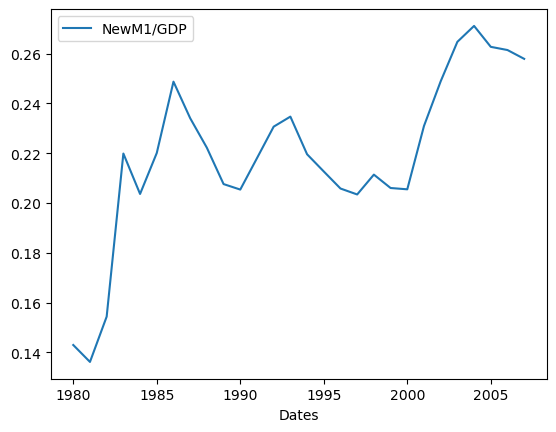

In [10]:
# M/PY using M1 (sweep adjusted) data for M, nominal GDP for PY
dcut.plot(y='NewM1/GDP')

<Axes: xlabel='Dates'>

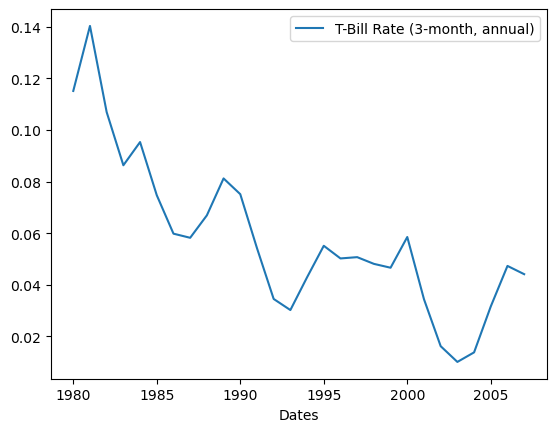

In [11]:
# T-Bill Rate (3-month, annual) 
dcut.plot(y='T-Bill Rate (3-month, annual)')

<Axes: xlabel='Dates'>

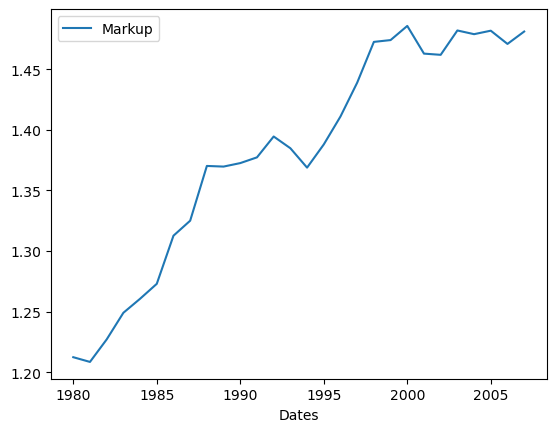

In [12]:
# Firm markup
dcut.plot(y='Markup')

<Axes: xlabel='Dates'>

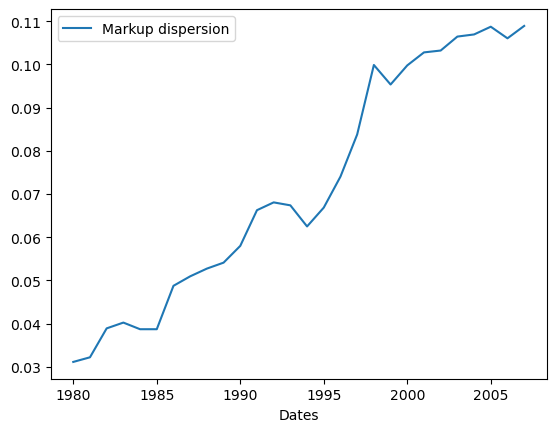

In [13]:
# Firm markup dispersion
dcut.plot(y='Markup dispersion')

<Axes: xlabel='T-Bill Rate (3-month, annual)', ylabel='NewM1/GDP'>

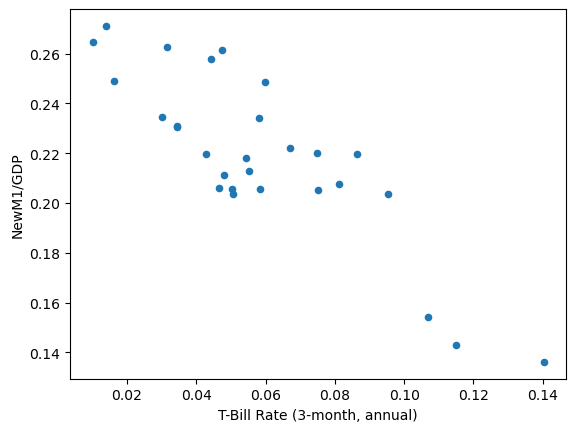

In [14]:
# Scatter plot M/PY vs. Federal Funds Rate
dcut.plot(x='T-Bill Rate (3-month, annual)', y='NewM1/GDP', kind='scatter')

<Axes: xlabel='T-Bill Rate (3-month, annual)', ylabel='Markup'>

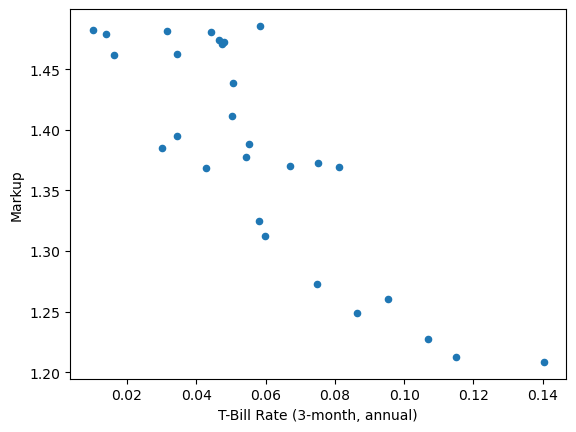

In [15]:
# Scatter plot Federal Funds Rate vs. Markup
dcut.plot(x='T-Bill Rate (3-month, annual)', y='Markup', kind='scatter')

<Axes: xlabel='T-Bill Rate (3-month, annual)', ylabel='Inflation (CPI, raw)'>

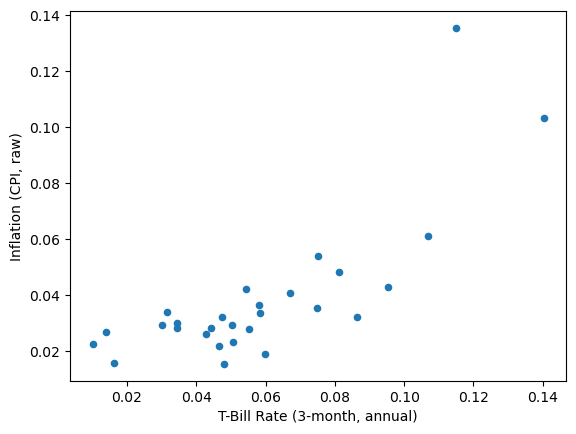

In [16]:
# Scatter plot Federal Funds Rate vs. inflation
dcut.plot(x='T-Bill Rate (3-month, annual)', y='Inflation (CPI, raw)', kind='scatter')

In [17]:
# Truncated sample (1980-2007) stats
dcut_mean = dcut.mean().to_frame()
dcut_mean.columns = ["sample mean"]
dcut_mean

,sample mean
Dates,1993.500000
"T-Bill Rate (3-month, annual)",0.058154
NewM1/GDP,0.219311
Markup,1.381942
Markup dispersion,0.071833
"Inflation (CPI, raw)",0.038494


In [18]:
T_bill_mean = 0.058154
τ_mean = 0.038494
#Use Fisher relation to back out the discount factor
β_data= (1.0+τ_mean)/(1.0+T_bill_mean)
print(β_data)


0.9814204737684685


### Visualization tool

In [42]:

def func(x, a, b, c):
    return a*np.exp(-b * x) + c 

def money_func_fit(x, y):
    data = np.asarray(sorted(zip(x,y)))
    i_set = np.linspace(data[:,0].min(), data[:,0].max())
    popt, pcov = curve_fit(func, x, y, bounds=(0.001, 10.0))
    fitted_func = func(i_set, *popt)
    return fitted_func

def markup_func_fit(x,y):
    data = np.asarray(sorted(zip(x,y)))
    i_set = np.linspace(data[:,0].min(), data[:,0].max())
    popt, pcov = curve_fit(func, x, y, bounds=(0.001, 10.0))
    fitted_func = func(i_set, *popt)
    return fitted_func

def visualization(x = dcut['T-Bill Rate (3-month, annual)'].tolist(),\
                  y = dcut['Markup'].tolist(),\
                  x_label = 'T-Bill Rate (3-month, annual)',\
                  y_label = 'Markup',\
                  model_x = np.linspace(0.0,0.0,1),\
                  model_y = np.linspace(0.0,0.0,1)
                 ):
    data = np.asarray(sorted(zip(x,y)))
   
    i_set = np.linspace(data[:,0].min(), data[:,0].max())
    if y_label == 'NewM1/GDP':
        popt, pcov = curve_fit(func, x, y, bounds=(0.001, 10.0))
    else:
        popt, pcov = curve_fit(func, x, y, bounds=(0.001, 10.0))
    fitted_func = func(i_set, *popt)
    if y_label == 'NewM1/GDP':
        plt.scatter(x, y, label='Data: 1980-2007')
        plt.plot(i_set, fitted_func, '--', color='r', label='Fitted spline')
        plt.plot(model_x, model_y, '-g', label="Model")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xlim(0.0, 0.16)
        plt.ylim(0.1, 0.4)
        plt.legend()
        plt.show()
    else:
        plt.scatter(x, y, label='Data: 1980-2007')
        plt.plot(i_set, fitted_func, '--', color='r', label='Fitted spline')
        plt.plot(model_x, model_y, '-g', label="Model")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xlim(0.0, 0.16)
        plt.ylim(1.0, 1.6)
        plt.legend()
        plt.show()    
    return fitted_func


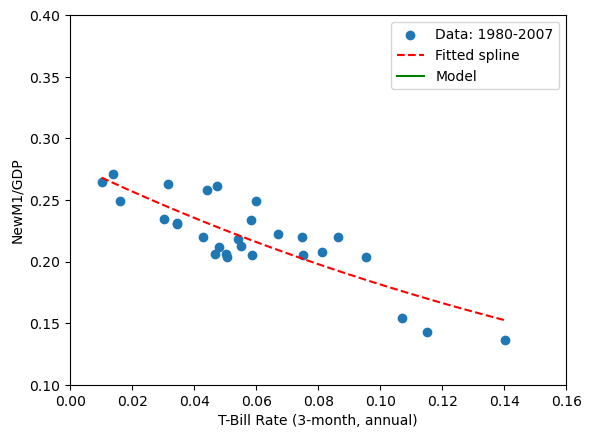

In [43]:
M1_GDP_fit_target =visualization(x = dcut['T-Bill Rate (3-month, annual)'].tolist(),\
                  y = dcut['NewM1/GDP'].tolist(),\
                  x_label = 'T-Bill Rate (3-month, annual)',\
                  y_label = 'NewM1/GDP',\
                  model_x = np.linspace(0.0,0.0,50),\
                  model_y = np.linspace(0.0,0.0,50))

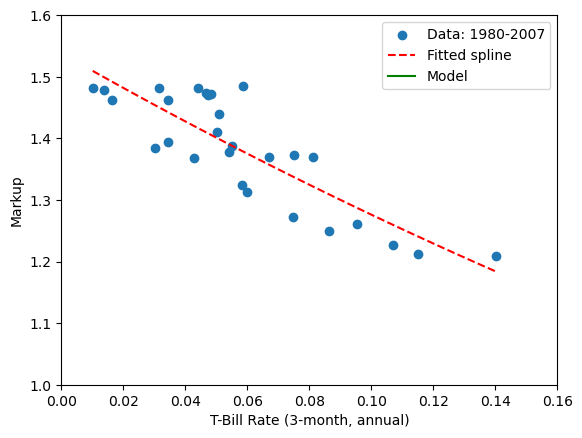

In [44]:
markup_fit_target=visualization(x = dcut['T-Bill Rate (3-month, annual)'].tolist(),\
                  y = dcut['Markup'].tolist(),\
                  x_label = 'T-Bill Rate (3-month, annual)',\
                  y_label = 'Markup',\
                  model_x = np.linspace(0.0,0.0,1),\
                  model_y = np.linspace(0.0,0.0,1))

### Store targets for calibration below

In [22]:
markup_target = markup_fit_target
M1_GDP_target = M1_GDP_fit_target

In [23]:
def ols(x, y):
    # Linear best fit:
    deg = 1 # OLS for linear best fit equation
    bols = np.polyfit(x, y, deg, rcond=None, full=False)
    y = bols[1] + bols[0]*x
    return bols

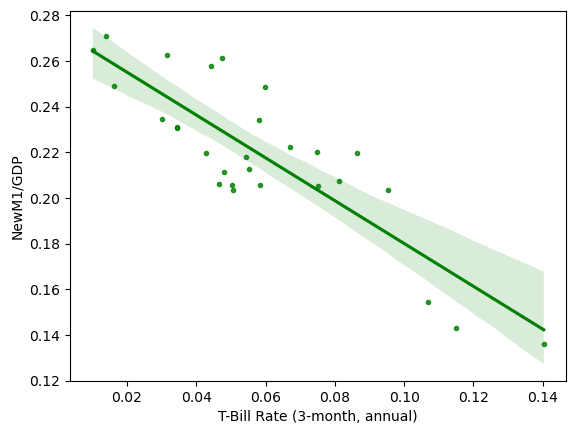

In [24]:
# Data
i_data = dcut['T-Bill Rate (3-month, annual)']
M1_GDP_data = dcut['NewM1/GDP']

plt.figure()
ax2 = sns.regplot(x=i_data, y=M1_GDP_data, 
                 data=None, 
                 fit_reg=True, 
                 x_estimator=None, 
                 marker=".", color="g") 

In [25]:
bols = ols(i_data, M1_GDP_data)
print("\nNow we approximate correlation: \n")
print("\t\tLinear Best Fit (Slope, Intercept) = ", str(bols), "\n")
    


Now we approximate correlation: 

		Linear Best Fit (Slope, Intercept) =  [-0.93747541  0.27382873] 



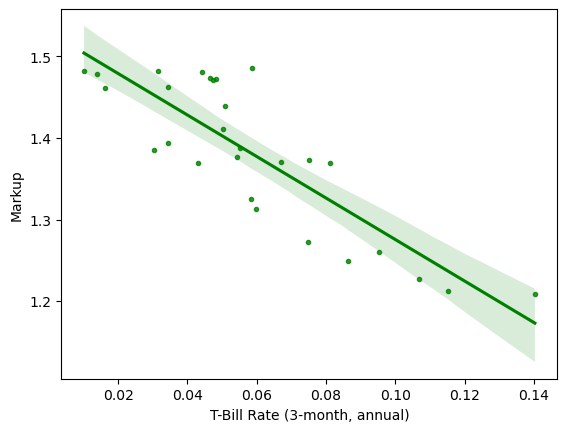

In [26]:
# Data
i_data = dcut['T-Bill Rate (3-month, annual)']
markup_data = dcut['Markup']

plt.figure()
ax2 = sns.regplot(x=i_data, y=markup_data, 
                 data=None, 
                 fit_reg=True, 
                 x_estimator=None, 
                 marker=".", color="g") 

In [27]:
bols_markup = ols(i_data, markup_data)
print("\nNow we approximate correlation: \n")
print("\t\tLinear Best Fit (Slope, Intercept) = ", str(bols_markup), "\n")
    


Now we approximate correlation: 

		Linear Best Fit (Slope, Intercept) =  [-2.5445708   1.52991806] 



In [28]:
from datetime import date

today = date.today()

## Calibration 

In [29]:
import klln_baseline_calibration as klln

In [30]:
σ_DM_range = np.linspace(0.28, 0.29, 3)  
Ubar_CM_range = np.linspace(1.89, 1.905, 3)
λ_range = np.linspace(0.61,0.62, 3)


#create a for-loop parameter value table
KLLN_class = np.array( [klln.baseline_mod(β=β_data, σ_CM=1.0, σ_DM=i, λ =j, Ubar_CM=n) \
                            for (i, j, n) in product(σ_DM_range,\
                                                        λ_range,\
                                                        Ubar_CM_range)]) 
    

print(KLLN_class.size)


27


* each index corresponds to a class with 1 possible combination of parameter values in the for-loop parameter table 

In [31]:
print(KLLN_class[0].σ_DM, KLLN_class[0].λ, KLLN_class[0].σ_CM, KLLN_class[0].Ubar_CM)
print(KLLN_class[1].σ_DM, KLLN_class[1].λ, KLLN_class[1].σ_CM, KLLN_class[1].Ubar_CM)

0.28 0.61 1.0 1.89
0.28 0.61 1.0 1.8975


In [32]:
def L(M1_GDP_target):
    """distance function between model simulated stat vs. spline-fitted data target"""
    
    L_diff = np.zeros(KLLN_class.size)
    
    for idx, x in enumerate(KLLN_class):
        # each idx is a particular class instantiation with particular 
        # parameter values in the parameter for-loop table
        
        # get SME result (dictionary)
        # note: this solver has equilibrium conditions check
        z_guess, i_guess = 0.4, 0.01
        result = KLLN_class[idx].SME_stat(z_guess, i_guess)
        
        # extract model implied M/PY array 
        # note: model M/P = z, and Y = CM consumption + total DM consumption
        mpy_grid = result['stat_grid']['mpy_star']

        i_FFR_grid = result['stat_grid']['FFR']
        
        w_mpy = 1.0/(stats.variance(M1_GDP_target))

        diff_M1_GDP =  np.abs(mpy_grid - M1_GDP_target) 
       
        L_diff_func = np.sum( w_mpy*(diff_M1_GDP)**2.0 )
    
        L_diff[idx] = L_diff_func.min()
               
    L_diff_min = L_diff[L_diff.argmin()]
    # get the corresponding class instantiation 
    KLLN_model = KLLN_class[L_diff.argmin()]
    # pick the corresponding value with minimum distance between model and target    
    model_result = KLLN_model.SME_stat(z_guess, i_guess)
    
    M1_GDP_star = model_result['stat_grid']['mpy_star']
    τ_mean = 0.038
    z_mean, i_mean = KLLN_model.solve_z_i(z_guess, i_guess, τ_mean)  
    markup_star = KLLN_model.markup_func(z_mean, i_mean, τ_mean) 
    i_policy_grid = model_result['stat_grid']['FFR']
  
    #implied parameter values that achieve the shortest distance between model and target
    σ_DM = KLLN_model.σ_DM
    σ_CM = KLLN_model.σ_CM
    λ = KLLN_model.λ
    Ubar_CM = KLLN_model.Ubar_CM    
    
    return  M1_GDP_star, markup_star,\
            i_policy_grid, σ_DM, σ_CM, λ, Ubar_CM,\
            L_diff_min, KLLN_model
       

In [33]:
tic = time.time()
M1_GDP_star, markup_star, i_policy_grid, σ_DM, σ_CM, λ, Ubar_CM,\
            L_diff_min, KLLN_model = L(M1_GDP_target)           
toc = time.time()-tic
print(toc, "seconds")

Elapsed time of solving SME: 402.84291982650757 seconds
Elapsed time of solving SME: 408.66421842575073 seconds
Elapsed time of solving SME: 397.7867033481598 seconds
Elapsed time of solving SME: 376.22618079185486 seconds
Elapsed time of solving SME: 359.30055594444275 seconds
Elapsed time of solving SME: 358.8223330974579 seconds
Elapsed time of solving SME: 359.0409314632416 seconds
Elapsed time of solving SME: 375.5133411884308 seconds
Elapsed time of solving SME: 381.55152225494385 seconds
Elapsed time of solving SME: 383.9277744293213 seconds
Elapsed time of solving SME: 384.1407721042633 seconds
Elapsed time of solving SME: 384.2730484008789 seconds
Elapsed time of solving SME: 383.37393283843994 seconds
Elapsed time of solving SME: 393.57326555252075 seconds
Elapsed time of solving SME: 394.66467213630676 seconds
Elapsed time of solving SME: 379.2561602592468 seconds
Elapsed time of solving SME: 379.1337978839874 seconds
Elapsed time of solving SME: 380.10436177253723 seconds
E

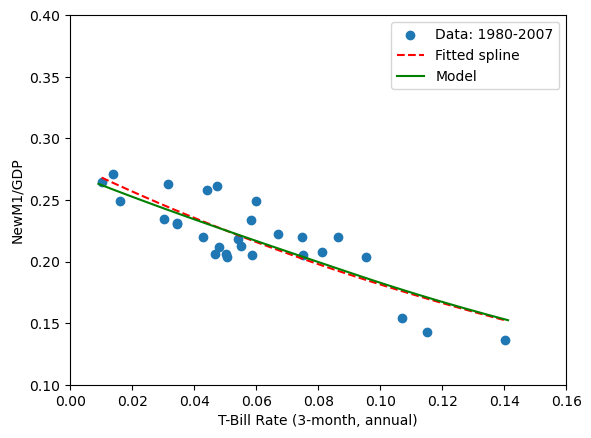

In [45]:
M1_GDP_data = visualization(x=dcut['T-Bill Rate (3-month, annual)'].tolist(),\
                                                   y=dcut['NewM1/GDP'].tolist(),\
                                                   model_x = i_policy_grid,\
                                                   model_y = M1_GDP_star,\
                                                   x_label='T-Bill Rate (3-month, annual)',\
                                                   y_label='NewM1/GDP')

In [46]:
rowlabels = ["$\sigma_{DM}$", "B (Ubar_CM)",\
             "$λ$"]

model_para = [ σ_DM, Ubar_CM, λ]
model_para_table = { "Calibrated parameters": rowlabels,
                     "Model (Avg)": model_para                
                   }
# Create dataframe
df_model_parameter = pd.DataFrame(data=model_para_table)
df_model_parameter

,Calibrated parameters,Model (Avg)
0,$\sigma_{DM}$,0.2800
1,B (Ubar_CM),1.8975
2,$λ$,0.6200


In [47]:
markup_star 

1.2768515909617117

In [48]:
rowlabels = ["$μ$"]

model_para = [λ]
model_para_table = { "Average markup": rowlabels,  
                     "Model": np.round(markup_star, 4),
                     "Data": 1.3 
                   }
# Create dataframe
df_model_data = pd.DataFrame(data=model_para_table)
df_model_data

,Average markup,Model,Data
0,$μ$,1.2769,1.3


In [49]:
import tikzplotlib

In [50]:
x_data=dcut['T-Bill Rate (3-month, annual)'].tolist()
y_data=dcut['NewM1/GDP'].tolist()
data = np.asarray(sorted(zip(x_data,y_data)))
i_set = np.linspace(data[:,0].min(), data[:,0].max())
money_fitted_func = money_func_fit(x_data,y_data)

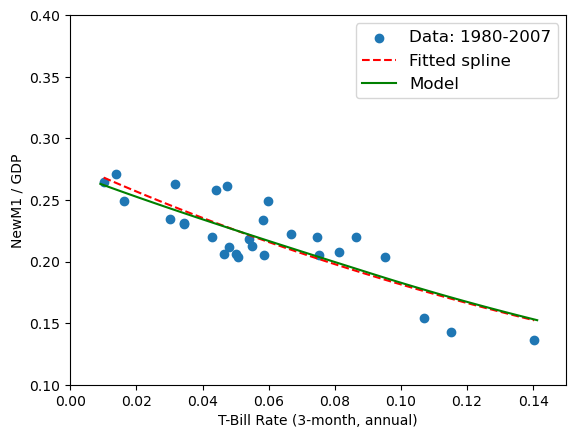

In [63]:
plt.style.use(style='default')
plt.scatter(x_data, y_data, label="Data: 1980-2007")
plt.plot(i_set, money_fitted_func, '--', color='r', label='Fitted spline')
plt.plot(i_policy_grid, M1_GDP_star, '-', color='green', label="Model")
plt.xlabel('T-Bill Rate (3-month, annual)')
plt.ylabel('NewM1 / GDP')
plt.xlim(0.0, 0.15)
plt.ylim(0.1, 0.4)
plt.legend(fontsize=12)
plt.savefig("m1_gdp_model_fit.png", dpi=800)

#tikzplotlib.save("m1_gdp_model_fit.tex")
#tikzplotlib.save("m1_gdp_model_fit.pgf")